## Implementation of SPKF to estimate SOC using ESC model
This notebook shows one way to implement an SOC estimator using a sigma-point Kalman filter and an enhanced self-correcting cell model. The "helper functions" were the topic of lesson 3.5.5, and the main "wrapper code" was the topic of lesson 3.5.6.

In [1]:
% First, make sure that the ESC toolbox functions are in the path
addpath readonly

The following is the "helper function" used to initialize the SPKF data structures.

In [2]:
function spkfData = initSPKF(v0,T0,SigmaX0,SigmaV,SigmaW,model)

  % Initial state description
  ir0   = 0;                           spkfData.irInd = 1;
  hk0   = 0;                           spkfData.hkInd = 2;
  SOC0  = SOCfromOCVtemp(v0,T0,model); spkfData.zkInd = 3;
  spkfData.xhat  = [ir0 hk0 SOC0]'; % initial state

  % Covariance values
  spkfData.SigmaX = SigmaX0;
  spkfData.SigmaV = SigmaV;
  spkfData.SigmaW = SigmaW;
  spkfData.Snoise = real(chol(diag([SigmaW; SigmaV]),'lower'));
  spkfData.Qbump = 5;
  
  % SPKF specific parameters
  Nx = length(spkfData.xhat); spkfData.Nx = Nx; % state-vector length
  Ny = 1; spkfData.Ny = Ny; % measurement-vector length
  Nu = 1; spkfData.Nu = Nu; % input-vector length
  Nw = size(SigmaW,1); spkfData.Nw = Nw; % process-noise-vector length
  Nv = size(SigmaV,1); spkfData.Nv = Nv; % sensor-noise-vector length
  Na = Nx+Nw+Nv; spkfData.Na = Na;     % augmented-state-vector length
  
  h = sqrt(3); h = 3;
  spkfData.h = h; % SPKF/CDKF tuning factor  
  Weight1 = (h*h-Na)/(h*h); % weighting factors when computing mean
  Weight2 = 1/(2*h*h);      % and covariance
  spkfData.Wm = [Weight1; Weight2*ones(2*Na,1)]; % mean
  spkfData.Wc = spkfData.Wm;                     % covar

  % previous value of current
  spkfData.priorI = 0;
  spkfData.signIk = 0;
  
  % store model data structure too
  spkfData.model = model;
end  

The following is the "helper function" to update the SPKF data structures every measurement interval.

In [3]:
function [zk,zkbnd,spkfData] = iterSPKF(vk,ik,Tk,deltat,spkfData)
  model = spkfData.model;

  % Load the cell model parameters
  Q  = getParamESC('QParam',Tk,model);
  G  = getParamESC('GParam',Tk,model);
  M  = getParamESC('MParam',Tk,model);
  M0 = getParamESC('M0Param',Tk,model);
  RC = exp(-deltat./abs(getParamESC('RCParam',Tk,model)))';
  R  = getParamESC('RParam',Tk,model)';
  R0 = getParamESC('R0Param',Tk,model);
  eta = getParamESC('etaParam',Tk,model);
  if ik<0, ik=ik*eta; end;
  
  % Get data stored in spkfData structure
  I = spkfData.priorI;
  SigmaX = spkfData.SigmaX;
  xhat = spkfData.xhat;
  Nx = spkfData.Nx;
  Nw = spkfData.Nw;
  Nv = spkfData.Nv;
  Na = spkfData.Na;
  Snoise = spkfData.Snoise;
  Wc = spkfData.Wc;
  irInd = spkfData.irInd;
  hkInd = spkfData.hkInd;
  zkInd = spkfData.zkInd;
  if abs(ik)>Q/100, spkfData.signIk = sign(ik); end;
  signIk = spkfData.signIk;
  
  % Step 1a: State estimate time update
  %          - Create xhatminus augmented SigmaX points
  %          - Extract xhatminus state SigmaX points
  %          - Compute weighted average xhatminus(k)

  % Step 1a-1: Create augmented SigmaX and xhat
  [sigmaXa,p] = chol(SigmaX,'lower'); 
  if p>0,
    fprintf('Cholesky error.  Recovering...\n');
    theAbsDiag = abs(diag(SigmaX));
    sigmaXa = diag(max(SQRT(theAbsDiag),SQRT(spkfData.SigmaW)));
  end
  sigmaXa=[real(sigmaXa) zeros([Nx Nw+Nv]); zeros([Nw+Nv Nx]) Snoise];
  xhata = [xhat; zeros([Nw+Nv 1])];
  % NOTE: sigmaXa is lower-triangular

  % Step 1a-2: Calculate SigmaX points (strange indexing of xhata to 
  % avoid "repmat" call, which is very inefficient in MATLAB)
  Xa = xhata(:,ones([1 2*Na+1])) + ...
       spkfData.h*[zeros([Na 1]), sigmaXa, -sigmaXa];

  % Step 1a-3: Time update from last iteration until now
  %     stateEqn(xold,current,xnoise)
  Xx = stateEqn(Xa(1:Nx,:),I,Xa(Nx+1:Nx+Nw,:)); 
  xhat = Xx*spkfData.Wm;

  % Step 1b: Error covariance time update
  %          - Compute weighted covariance sigmaminus(k)
  %            (strange indexing of xhat to avoid "repmat" call)
  Xs = Xx - xhat(:,ones([1 2*Na+1]));
  SigmaX = Xs*diag(Wc)*Xs';
  
  % Step 1c: Output estimate
  %          - Compute weighted output estimate yhat(k)
  I = ik; yk = vk;
  Y = outputEqn(Xx,I,Xa(Nx+Nw+1:end,:),Tk,model);
  yhat = Y*spkfData.Wm;

  % Step 2a: Estimator gain matrix
  Ys = Y - yhat(:,ones([1 2*Na+1]));
  SigmaXY = Xs*diag(Wc)*Ys';
  SigmaY = Ys*diag(Wc)*Ys';
  L = SigmaXY/SigmaY; 

  % Step 2b: State estimate measurement update
  r = yk - yhat; % residual.  Use to check for sensor errors...
  if r^2 > 100*SigmaY, L(:,1)=0.0; end 
  xhat = xhat + L*r; 
  xhat(zkInd)=min(1.05,max(-0.05,xhat(zkInd)));
  xhat(hkInd) = min(1,max(-1,xhat(hkInd)));

  % Step 2c: Error covariance measurement update
  SigmaX = SigmaX - L*SigmaY*L';
  [~,S,V] = svd(SigmaX);
  HH = V*S*V';
  SigmaX = (SigmaX + SigmaX' + HH + HH')/4; % Help maintain robustness
  
  % Q-bump code
  if r^2>4*SigmaY, % bad voltage estimate by 2-SigmaX, bump Q 
    fprintf('Bumping sigmax\n');
    SigmaX(zkInd,zkInd) = SigmaX(zkInd,zkInd)*spkfData.Qbump;
  end
  
  % Save data in spkfData structure for next time...
  spkfData.priorI = ik;
  spkfData.SigmaX = SigmaX;
  spkfData.xhat = xhat;
  zk = xhat(zkInd);
  zkbnd = 3*sqrt(SigmaX(zkInd,zkInd));
  
  % Calculate new states for all of the old state vectors in xold.  
  function xnew = stateEqn(xold,current,xnoise)
    current = current + xnoise; % noise adds to current
    xnew = 0*xold;
    xnew(irInd,:) = RC*xold(irInd,:) + (1-diag(RC))*current;
    Ah = exp(-abs(current*G*deltat/(3600*Q)));  % hysteresis factor
    xnew(hkInd,:) = Ah.*xold(hkInd,:) + (Ah-1).*sign(current);
    xnew(zkInd,:) = xold(zkInd,:) - current/3600/Q;
    xnew(hkInd,:) = min(1,max(-1,xnew(hkInd,:)));
    xnew(zkInd,:) = min(1.05,max(-0.05,xnew(zkInd,:)));
  end

  % Calculate cell output voltage for all of state vectors in xhat
  function yhat = outputEqn(xhat,current,ynoise,T,model)
    yhat = OCVfromSOCtemp(xhat(zkInd,:),T,model);
    yhat = yhat + M*xhat(hkInd,:) + M0*signIk;
    yhat = yhat - R*xhat(irInd,:) - R0*current + ynoise(1,:);
  end

  % "Safe" square root
  function X = SQRT(x)
    X = sqrt(max(0,x));
  end
end

The following "wrapper" code loads a lab-test data file, runs the EKF, and plots results. Make sure you type < shift >< enter> in the earlier "helper function" notebook cells before executing the "wrapper code".

Please be patient. This code will take several minutes to execute.
  Completed 1000 out of 35560 iterations...
  Completed 2000 out of 35560 iterations...
  Completed 3000 out of 35560 iterations...
  Completed 4000 out of 35560 iterations...
  Completed 5000 out of 35560 iterations...
  Completed 6000 out of 35560 iterations...
  Completed 7000 out of 35560 iterations...
  Completed 8000 out of 35560 iterations...
  Completed 9000 out of 35560 iterations...
  Completed 10000 out of 35560 iterations...
  Completed 11000 out of 35560 iterations...
  Completed 12000 out of 35560 iterations...
  Completed 13000 out of 35560 iterations...
  Completed 14000 out of 35560 iterations...
  Completed 15000 out of 35560 iterations...
  Completed 16000 out of 35560 iterations...
  Completed 17000 out of 35560 iterations...
  Completed 18000 out of 35560 iterations...
  Completed 19000 out of 35560 iterations...
  Completed 20000 out of 35560 iterations...
  Completed 21000 out of 35560 iterations.

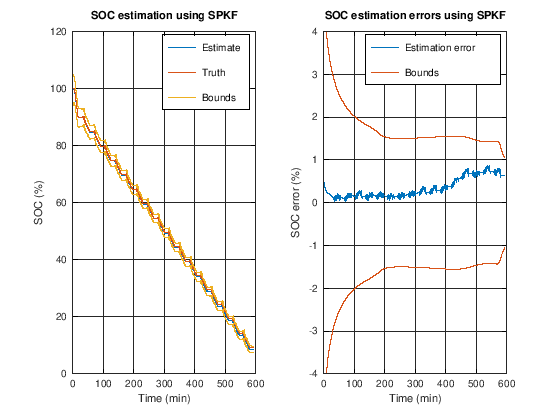

In [4]:
% Load model file corresponding to a cell of this type
% Has the variables: current, SOC, time, voltage
load readonly/PANdata_P45.mat; % load data from Panasonic NMC cell, +45 degC
T = 45; % Test temperature

time    = DYNData.script1.time(:);   deltat = time(2)-time(1);
time    = time-time(1); % start time at 0
current = DYNData.script1.current(:); % discharge > 0; charge < 0.
voltage = DYNData.script1.voltage(:);
soc     = DYNData.script1.soc(:);

% Load cell-test data to be used for this batch experiment
% Contains variable "DYNData" of which the field "script1" is of 
% interest. This has sub-fields time, current, voltage, soc.
load readonly/PANmodel.mat; % load ESC model of Panasonic NMC cell

% Reserve storage for computed results, for plotting
sochat = zeros(size(soc));
socbound = zeros(size(soc));

% Covariance values
SigmaX0 = diag([1e2 1e-2 1e-3]); % uncertainty of initial state
SigmaV = 3e-1; % Uncertainty of voltage sensor, output equation
SigmaW = 4e0; % Uncertainty of current sensor, state equation

% Create spkfData structure and initialize variables using first
% voltage measurement and first temperature measurement
spkfData = initSPKF(voltage(1),T,SigmaX0,SigmaV,SigmaW,model);

% Now, enter loop for remainder of time, where we update the SPKF
% once per sample interval
fprintf('Please be patient. This code will take several minutes to execute.\n')
for k = 1:length(voltage),
  vk = voltage(k); % "measure" voltage
  ik = current(k); % "measure" current
  Tk = T;          % "measure" temperature
  
  % Update SOC (and other model states)
  [sochat(k),socbound(k),spkfData] = iterSPKF(vk,ik,Tk,deltat,spkfData);
  % update waitbar periodically, but not too often (slow procedure)
  if mod(k,1000)==0,
    fprintf('  Completed %d out of %d iterations...\n',k,length(voltage));
  end  
end

%%
subplot(1,2,1); plot(time/60,100*sochat,time/60,100*soc); hold on
plot([time/60; NaN; time/60],[100*(sochat+socbound); NaN; 100*(sochat-socbound)]);
title('SOC estimation using SPKF'); grid on
xlabel('Time (min)'); ylabel('SOC (%)'); legend('Estimate','Truth','Bounds');

%%
a = 100*(soc-sochat);
#fprintf('RMS SOC estimation error = %g%%\n',sqrt(mean((100*(soc-sochat)).^2)));
fprintf('RMS SOC estimation error = %g%%\n',sqrt(mean(a).^2));

%%
subplot(1,2,2); plot(time/60,100*(soc-sochat)); hold on
plot([time/60; NaN; time/60],[100*socbound; NaN; -100*socbound]);
title('SOC estimation errors using SPKF');
xlabel('Time (min)'); ylabel('SOC error (%)'); ylim([-4 4]); 
legend('Estimation error','Bounds'); 
grid on

ind = find(abs(soc-sochat)>socbound);
fprintf('Percent of time error outside bounds = %g%%\n',length(ind)/length(soc)*100);

In [5]:
max(abs((a)))

ans =  0.86027
